In [1]:
import numpy as np
from sklearn import datasets
from sklearn import __version__ as sklearn_version
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn import tree
import pydotplus as pdp
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pandas as pd
import copy
%matplotlib inline

## 関数 dt_
- input : 
     - X : 入力データ
     - y : 出力データ
     - restrict : 制約（葉の数か深さか）
     - num : 葉数 or 深さ
     - random : シード
- output : 
    - dt : 決定木
    - X.columns : 入力データの特徴量（使用した特徴量ではない）


In [2]:
def dt_(X, y, restrict, num, random):
    
    if restrict == "depth":
        dt = DecisionTreeClassifier(max_depth = num, random_state=random)
    elif restrict == "leaf":
        dt = DecisionTreeClassifier(max_leaf_nodes = num, random_state=random)
    else:
        print("please input restrict tree by depth or leaf")
    
    dt.fit(X, y)
    
    #f_list = list(set(dt.tree_.feature))  #DT.tree_.feature : 決定木の分割に使われた変数を取得
    #f_list.remove(-2)
            
    return [dt, X.columns]

## 関数 enu
- input : 
    - X : 入力
    - y : 出力
    - restrict : 制約（葉の数か深さか）
    - num : 葉数 or 深さ
    - random : シード
- output : 
    - rashomon set : list[gain importance, permutation importance]

In [3]:
def enu(X, y, restrict, num, random, model_num):
    
    # dt_X : モデルと入力データの特徴量の組を格納するリスト
    # f_list : 計算済みの入力データの特徴量を格納するリスト
    # rashomon : 羅生門集合に属するモデル，予測精度，gain importance, permutation importance を格納するリスト
    dt_X, f_list = [], []
    rashomon = []
    score_list = []

    n = len(list(X.columns.values))
    column = list(range(n))
    X.columns = column # 暫定的に特徴量を[0, 1, ..., n-1] に置き換える
    
    # ベースライン決定木の作成
    base = dt_(X, y, restrict, num, random)
    dt_X.append(base)
    
    #print(X.head())
    f_list.append(list(X.columns.values))
    f_list.append([]) # 空集合を格納
    score = 1 - base[0].score(X, y)
    score_list.append(score)
    gain, per = get_fi(X, y, base[0], n)
    rashomon.append([gain, per])
    
    count = 1
    
    # dt_X が空になるまで実行
    while len(dt_X) != 0:
        dt_pop = dt_X.pop(0) # モデルと入力データの特徴量をポップ
        dt = dt_pop[0]
        X_use = list(dt_pop[1])
        feature = list(set(dt.tree_.feature))  #dt.tree_.feature : 決定木の分割に使われた変数を取得
        feature.remove(-2) # 葉ノード（-2）を削除
        
        #print("next " + str(feature) )

        for i in range(len(feature)):
            new_X = copy.copy(X_use) # 入力データの特徴量をコピー
            new_X.remove(X_use[feature[i]])
            
            if new_X in f_list: continue # 既に計算してたら計算しない
            
            f_list.append(new_X)
            new = dt_(X[new_X], y, restrict, num, random)
            score = 1 - new[0].score(X[new_X], y)
            
            if count < model_num:
                score_list.append(score)
                gain, per = get_fi(X[new_X], y, new[0], n)
                rashomon.append([gain, per])
            elif score < max(score_list):
                point = score_list.index(max(score_list))
                gain, per = get_fi(X[new_X], y, new[0], n)
                rashomon[point] = [gain, per]
                score_list[point] = score
            #print(new_X)
            #print(list(set(new[0].tree_.feature)) )
            dt_X.append(new)
            count += 1
            
    return rashomon, score_list

## 関数 get_fi
- input : 
    - X : input
    - y : label
    - model : predict model
    - n : 元データの特徴量の数
- output : 
    - gain importance
    - permutation importance

In [4]:
def get_fi(X, y, model, n):
    
    gain = [0.0]*n
    per = [0.0]*n
    
    # gain ベースの特徴量重要度を計算
    gain_fi = model.feature_importances_
    # permutation importance ベースの特徴量重要度を計算
    result = permutation_importance(model, X, y, n_repeats=5, random_state=0)
    per_fi = result.importances_mean/sum(result.importances_mean)
    
    feature = list(X.columns.values)
    for i in range(len(feature)):
        gain[feature[i]] = gain_fi[i]
        per[feature[i]] = per_fi[i]
        
    #print(gain)
    
    return gain, per    

## 関数 VIC_scatter
- input : 
    - VIC : VIC list 

In [20]:
def VIC_scatter(VIC, imp, feature_name):
    
    fi_list = []
    label = []
    
    for i in range(len(VIC[0])):
        fi = []
        for j in range(len(VIC)):
            fi.append(VIC[j][i])
        fi_list.append(fi)
        label.append("X{}".format(i))
        
    if len(feature_name) != 0: label = feature_name
     
    # 箱ひげ図
    fig, ax = plt.subplots(figsize=(20, 10))
    bp = ax.boxplot(fi_list)
    ax.set_xticklabels(label)
    # タイトル名
    plt.title("box plot of {} importance for german credit dataset by Lawler".format(imp))
    # ラベル名
    plt.xlabel("feature")
    plt.ylabel("feature importance")
    
    # 散布図行列
    df = pd.DataFrame(VIC, columns=label)

    g = sns.catplot(data=df, kind='swarm', height=10, aspect=2)
    g.set(ylim=(0.0, 0.6))
    g.fig.suptitle("swarm plot of {} importance for german credit dataset by Lawler".format(imp),
                      y=0.95, size=24)

## 関数 VIC_correlation
- input : 
    - VIC : VIC list 

In [25]:
def VIC_correlation(VIC, imp, feature_name):
    
    fi_list = []
    label = []
    
    for i in range(len(VIC[0])):
        fi = []
        for j in range(len(VIC)):
            fi.append(VIC[j][i])
        fi_list.append(fi)
        label.append("X{}".format(i))
        
    if len(feature_name) != 0: label = feature_name
    
    # 散布図行列
    df = pd.DataFrame(VIC, columns=label)
    
    corr = df.corr()
    plt.figure(figsize=(20, 10)) 
    sns.heatmap(corr, square=True, annot=True, cmap='hot')
    plt.title("heat map of correlation coefficients of {} importance for german credit dataset by Lawler".format(imp))
    
    g = sns.pairplot(df)
    g = g.map_upper(plt.scatter)
    g = g.map_lower(sns.kdeplot, cmap='hot', shade=True)
    g = g.map_diag(plt.hist)
    plt.subplots_adjust(top=0.9)
    g = g.fig.suptitle("pair plot of {} importance for german credit dataset by Lawler".format(imp),
                      y=0.95, size=24)

## Experiment for german credit

In [7]:
pd.set_option('display.max_columns', None)
data = pd.read_csv('data/german_credit/pre_german3.csv', index_col=0)
data.head()

,checking_account,duration,credit_history,credit_amount,installment_rete,sex,property,age,label,housing_own
0,1,6,4,1169,4,0,0,67,0,1
1,2,48,2,5951,2,1,0,22,1,1
2,0,12,4,2096,2,0,0,49,0,1
3,1,42,2,7882,2,0,1,45,0,0
4,1,24,3,4870,3,0,4,53,1,0


In [8]:
X = data.drop("label", axis=1)
print(X.head())
print("-" * 50)
y = data["label"]
print(y.head())

   checking_account  duration  credit_history  credit_amount  \
0                 1         6               4           1169   
1                 2        48               2           5951   
2                 0        12               4           2096   
3                 1        42               2           7882   
4                 1        24               3           4870   

   installment_rete  sex  property  age  housing_own  
0                 4    0         0   67            1  
1                 2    1         0   22            1  
2                 2    0         0   49            1  
3                 2    0         1   45            0  
4                 3    0         4   53            0  
--------------------------------------------------
0    0
1    1
2    0
3    0
4    1
Name: label, dtype: int64


In [9]:
base_dt = DecisionTreeClassifier(max_depth=9, random_state=0)
base_dt.fit(X, y)
base_score = 1 - base_dt.score(X, y)
print("base_score : " + str(base_score))

base_score : 0.124


In [10]:
rashomon, score_list = enu(X, y, "depth", 9, 0, 100)

In [22]:
print("base_score : " + str(base_score))
print("max score : " + str(max(score_list)))
print("epsilon : " + str(max(score_list)/base_score))

base_score : 0.124
max score : 0.14200000000000002
epsilon : 1.1451612903225807


In [11]:
print(len(rashomon))
print(rashomon[0])
print(rashomon[0][1])

100
[[0.20942016150239534, 0.16599828175879539, 0.07031492695844206, 0.2324178446781437, 0.04560917467304391, 0.030684960895192945, 0.06964707800800501, 0.1744148236400293, 0.0014927478859524607], [0.22802359882005893, 0.2188790560471976, 0.05575221238938056, 0.1843657817109144, 0.064306784660767, 0.0233038348082596, 0.06578171091445431, 0.14926253687315627, 0.010324483775811215]]
[0.22802359882005893, 0.2188790560471976, 0.05575221238938056, 0.1843657817109144, 0.064306784660767, 0.0233038348082596, 0.06578171091445431, 0.14926253687315627, 0.010324483775811215]


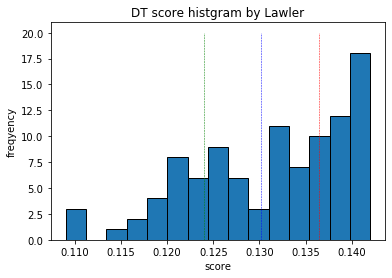

In [24]:
base_score = score_list[0]
hist, bin_edges = np.histogram(score_list, bins=20)
plt.title('DT score histgram by Lawler')
plt.xlabel('score')
plt.ylabel('freqyency')
plt.hist(score_list, bins=15, histtype='barstacked', ec='black')
# ε=1 に緑線
plt.vlines(base_score*1, 0, 20, "green", linestyle='dashed', linewidth=0.5)
# ε=1.05 に青い線
plt.vlines(base_score*1.05, 0, 20, "blue", linestyle='dashed', linewidth=0.5)
# ε=1.1 に赤い線
plt.vlines(base_score*1.1, 0, 20, "red", linestyle='dashed', linewidth=0.5)

In [13]:
gain = []
per = []

for i in range(len(rashomon)):
    gain.append(rashomon[i][0])
    per.append(rashomon[i][1])

feature_name = list(data.columns)
print(feature_name)
feature_name.remove("label")
print(feature_name)

['checking_account', 'duration', 'credit_history', 'credit_amount', 'installment_rete', 'sex', 'property', 'age', 'label', 'housing_own']
['checking_account', 'duration', 'credit_history', 'credit_amount', 'installment_rete', 'sex', 'property', 'age', 'housing_own']


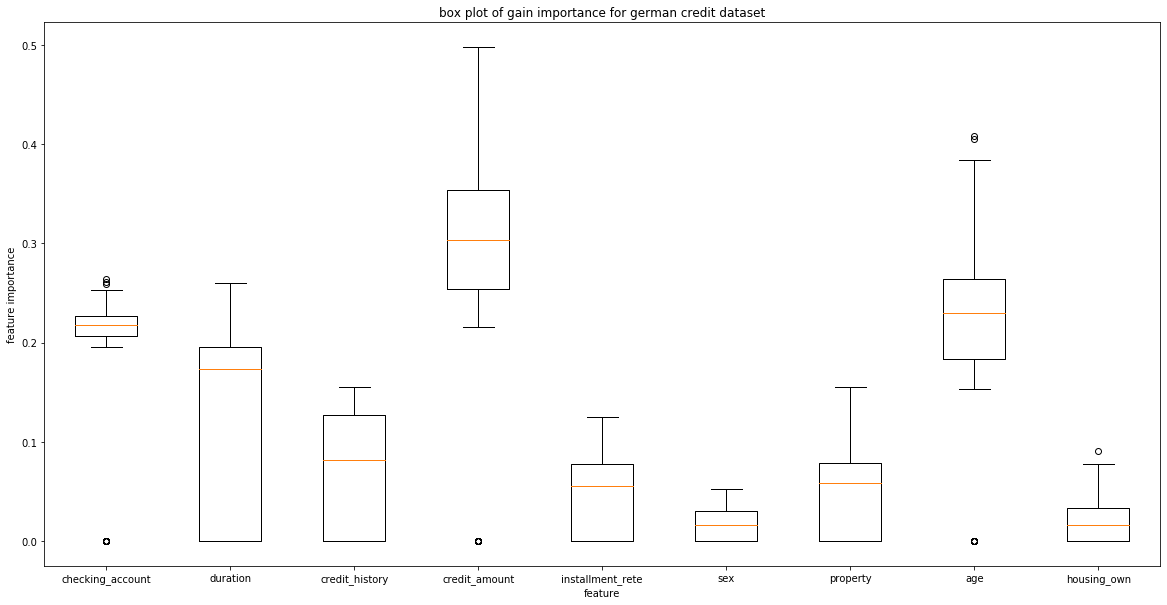

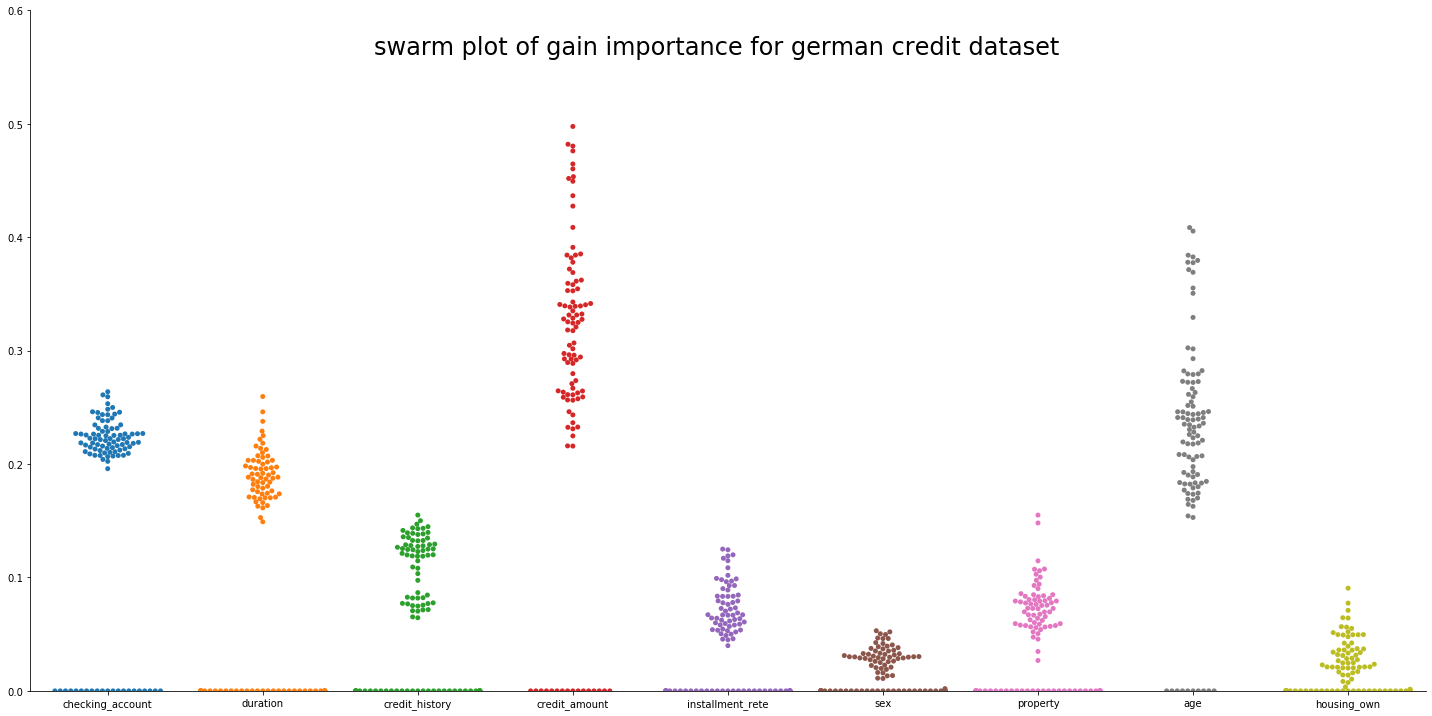

In [21]:
VIC_scatter(gain, "gain", feature_name)

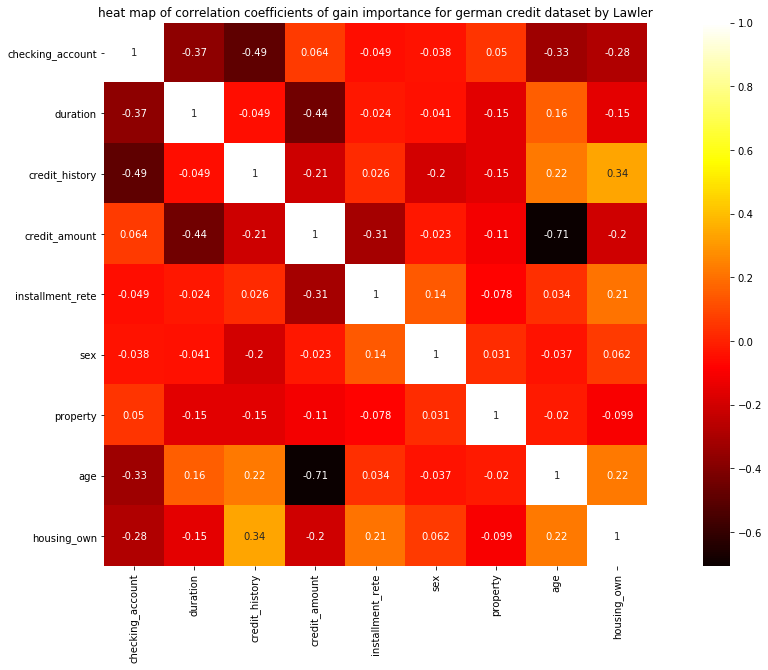

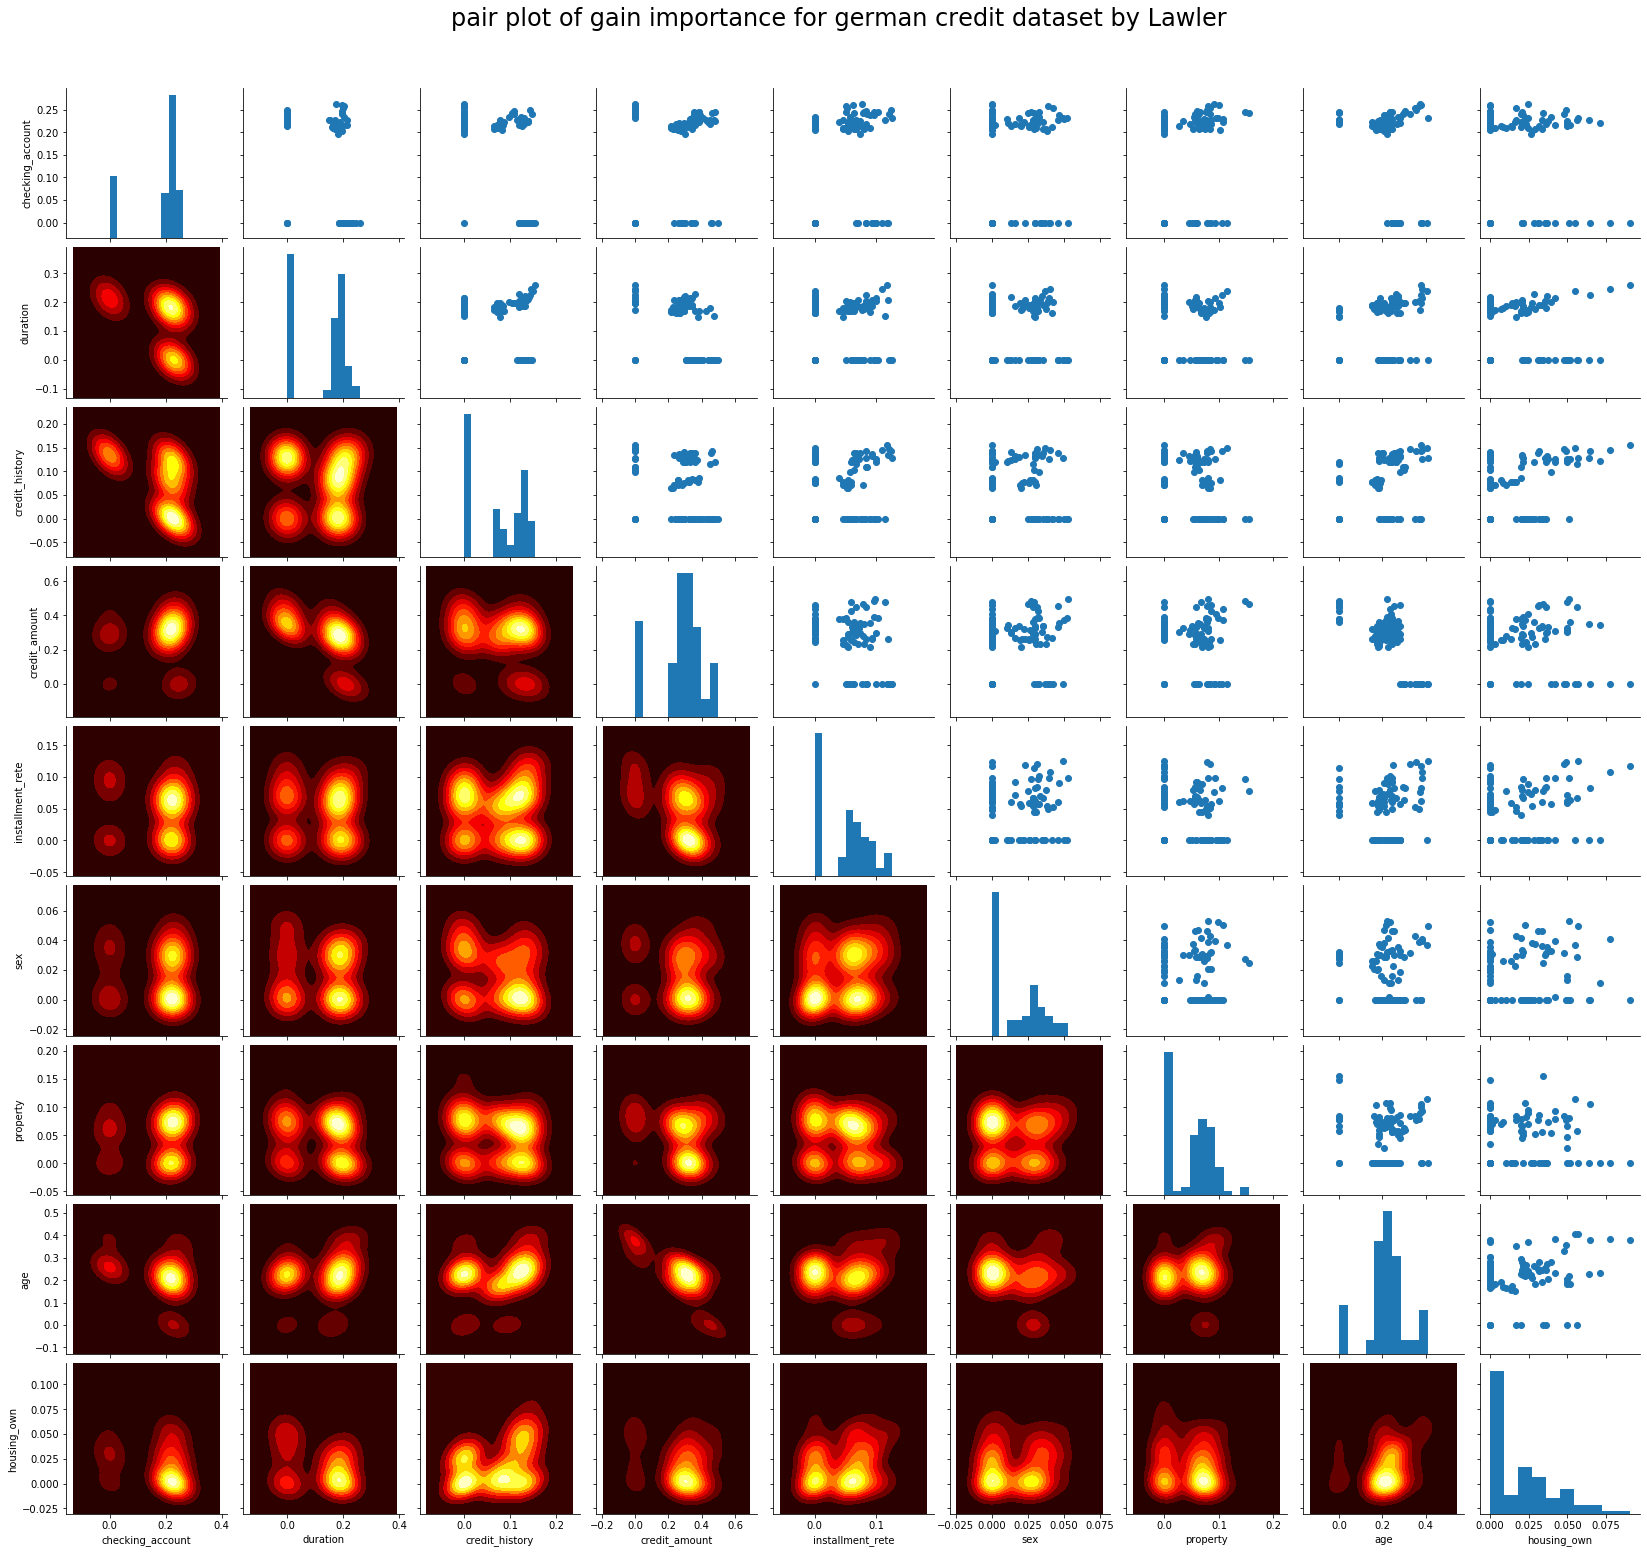

In [26]:
VIC_correlation(gain, "gain", feature_name)

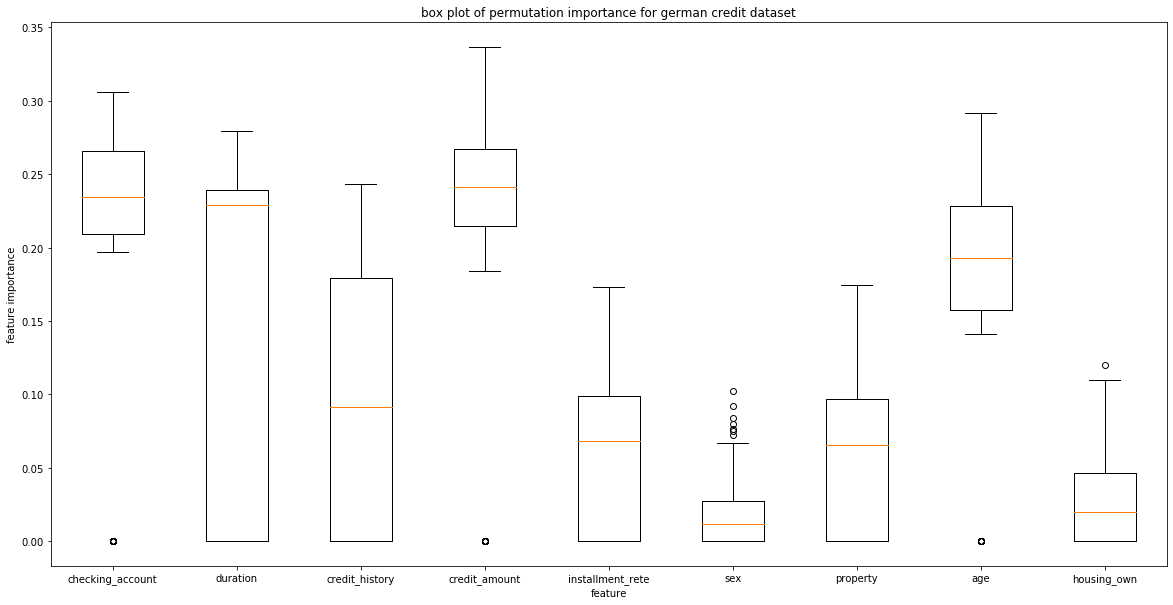

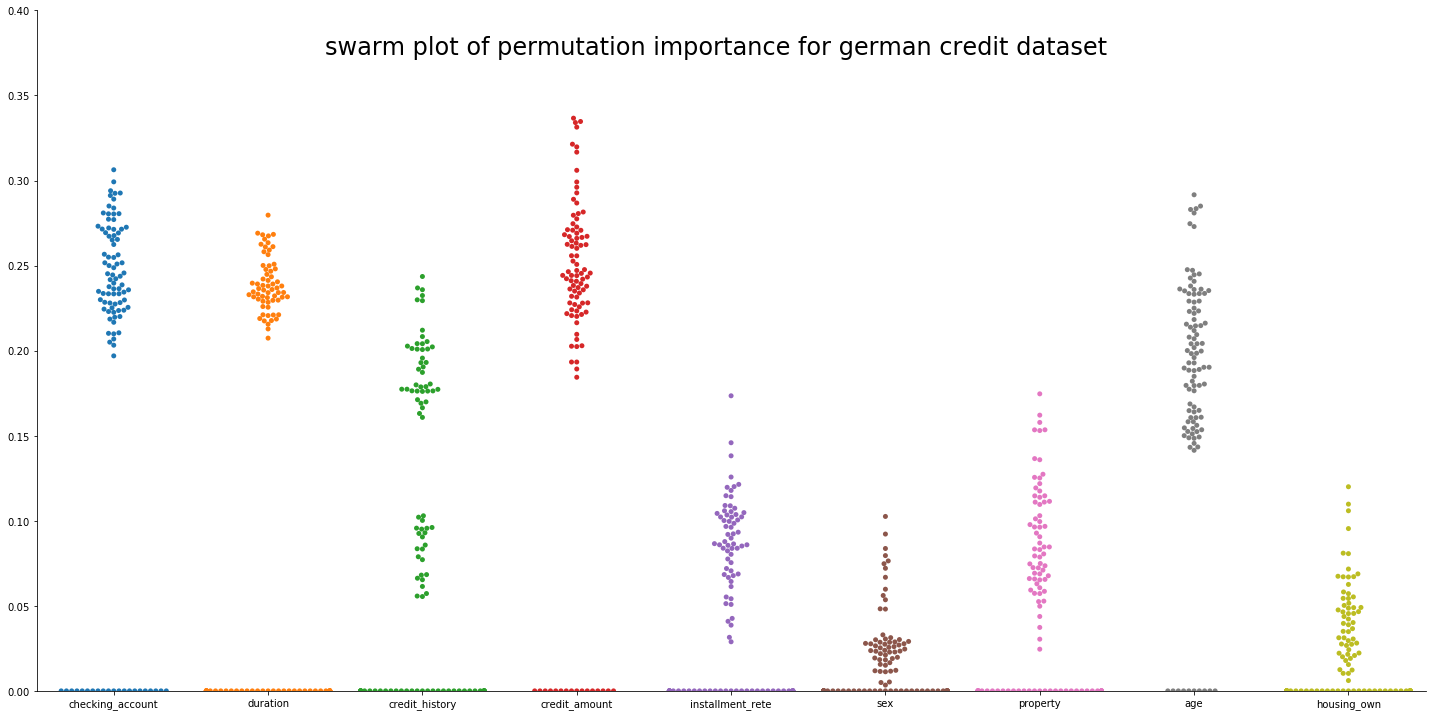

In [35]:
VIC_scatter(per, "permutation", feature_name)

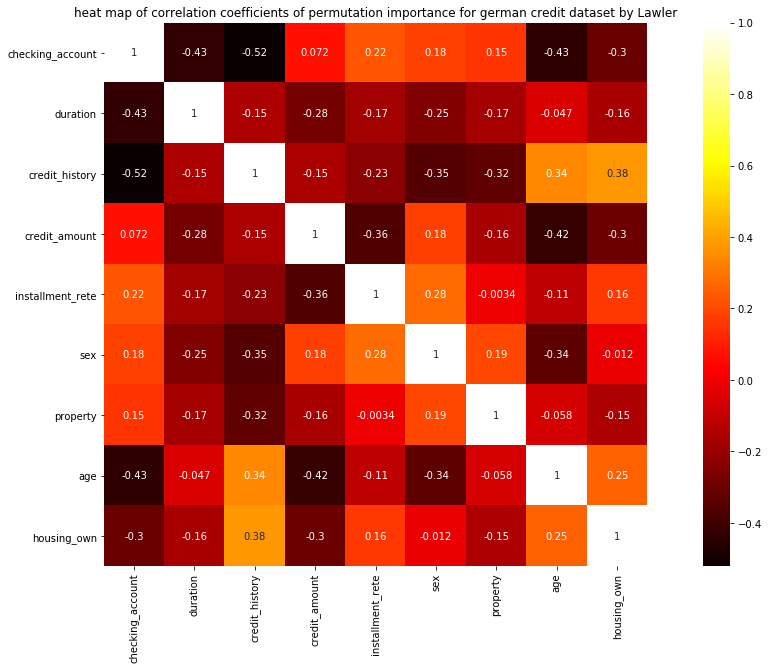

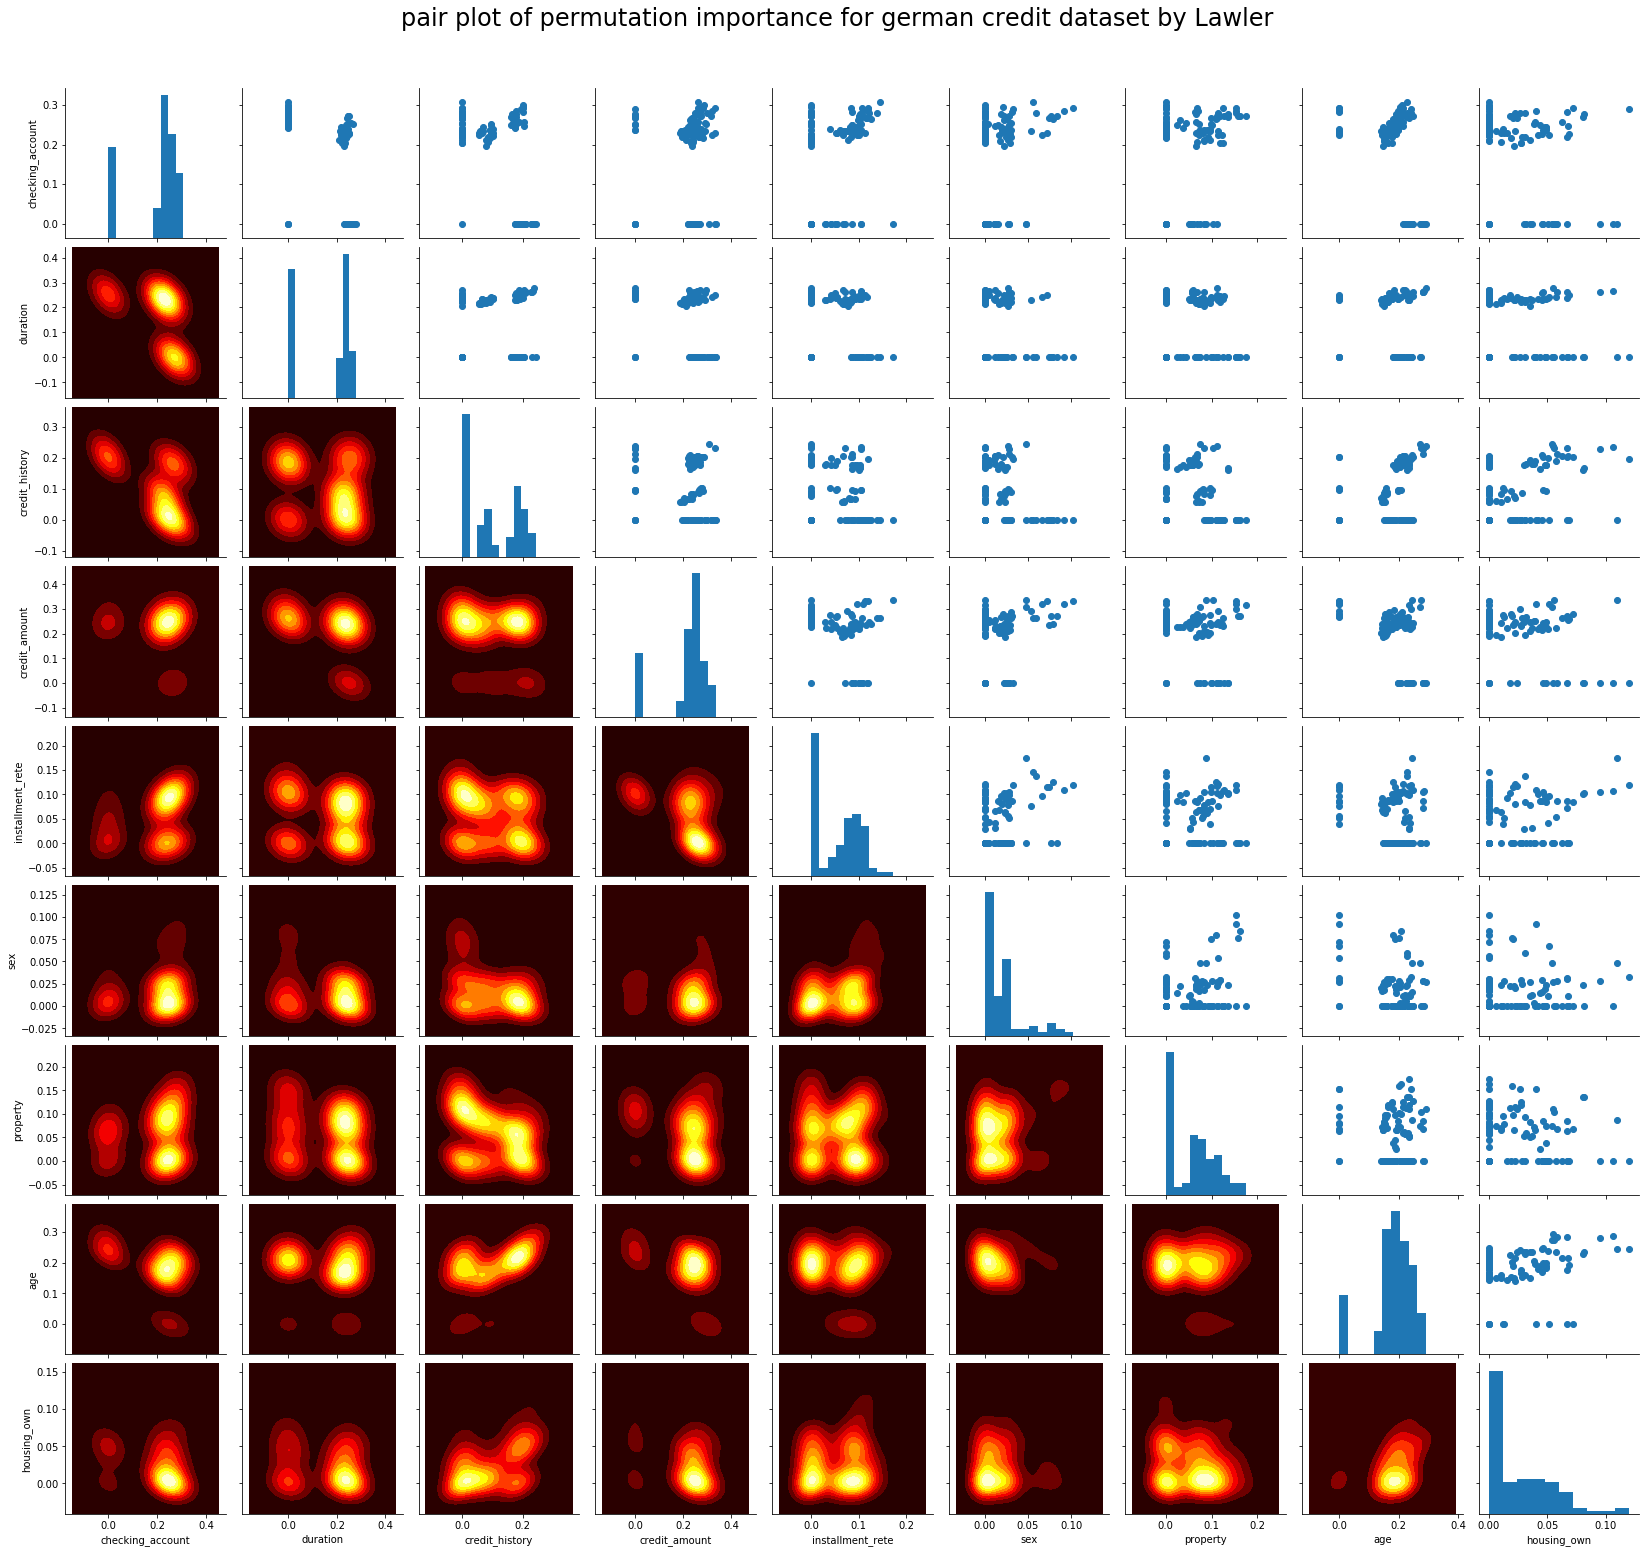

In [27]:
VIC_correlation(per, "permutation", feature_name)

['checking_account', 'duration', 'credit_history', 'credit_amount', 'installment_rete', 'sex', 'property', 'age', 'label', 'housing_own']
['checking_account', 'duration', 'credit_history', 'credit_amount', 'installment_rete', 'sex', 'property', 'age', 'housing_own']
